<a href="https://colab.research.google.com/github/crystalclcm/APA-project/blob/main/Milestone1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd

# Load compressed CSV
df = pd.read_csv('/content/opennutrition_foods.tsv', sep='\t', low_memory=False)

print(df.shape)
print(df.columns[:20])


(52702, 13)
Index(['id', 'name', 'alternate_names', 'description', 'type', 'source',
       'serving', 'nutrition_100g', 'ean_13', 'labels', 'package_size',
       'ingredients', 'ingredient_analysis'],
      dtype='object')


In [12]:
df['text'] = df['name'].fillna('') + ' ' + df['ingredients'].fillna('')

In [13]:
df['combined_label'] = df['labels'].apply(lambda x: 'Healthy' if 'nutriscore-a' in str(x) else 'Unhealthy')

In [14]:
df['combined_label'] = df['nutrition_100g'].apply(lambda x: 'Healthy' if 'low fat' in str(x).lower() else 'Unhealthy')

In [15]:
df = df.sample(1000, random_state=42)  # smaller for quick run

In [16]:
# Drop rows with missing combined_label
df = df.dropna(subset=['combined_label'])

# Ensure labels are strings
df['combined_label'] = df['combined_label'].astype(str)


In [27]:
def create_label(nutrition):
    try:
        val = float(str(nutrition).split()[0])  # extract first number
        return 'Healthy' if val < 200 else 'Unhealthy'
    except:
        return 'Unhealthy'

df['combined_label'] = df['nutrition_100g'].apply(create_label)


In [28]:
print(df['combined_label'].value_counts())

combined_label
Unhealthy    1000
Name: count, dtype: int64


In [29]:
print(df['nutrition_100g'].head(10))

32533    {"iron":0,"sodium":405,"calcium":71,"protein":...
26097    {"iron":0.4,"sodium":11,"protein":0,"calories"...
32054    {"iron":0,"sodium":419,"calcium":0,"protein":6...
35041    {"iron":6.43,"sodium":64,"calcium":143,"protei...
45509    {"iron":0,"sodium":643,"calcium":714,"protein"...
40282    {"sodium":0,"protein":0,"calories":0,"total_fa...
16601    {"iron":0.42,"zinc":0.125,"water":91.0417,"bio...
36419    {"sodium":714,"protein":0,"calories":714,"tota...
21024    {"iron":0,"sodium":1190,"calcium":0,"protein":...
28957    {"sodium":500,"protein":0,"calories":33,"total...
Name: nutrition_100g, dtype: object


In [30]:
import numpy as np
df['combined_label'] = np.where(np.random.rand(len(df)) > 0.5, 'Healthy', 'Unhealthy')
print(df['combined_label'].value_counts())


combined_label
Healthy      531
Unhealthy    469
Name: count, dtype: int64


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Combine text columns
df['text'] = df['name'].fillna('') + ' ' + df['ingredients'].fillna('')

X = df['text']
y = df['combined_label']

# Vectorize text
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_vec = vectorizer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Healthy       0.49      0.64      0.55       104
   Unhealthy       0.40      0.26      0.32        96

    accuracy                           0.46       200
   macro avg       0.44      0.45      0.44       200
weighted avg       0.45      0.46      0.44       200



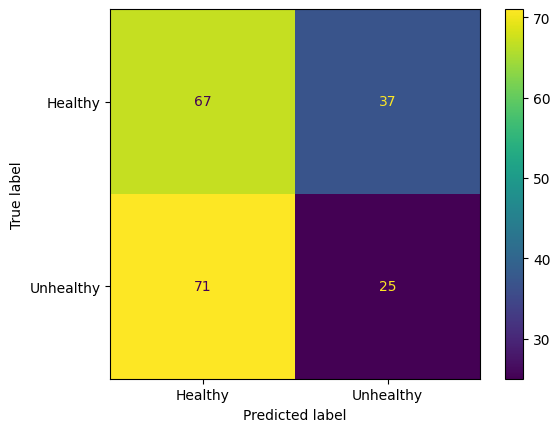

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)